# Cook membrane problem

Take a look at Daniels lecture nodes for the problem statement and from-scratch implementation in MATLAB.

In [37]:
import skfem 
from skfem.visuals.matplotlib import draw, plot
import numpy as np

## Material model

In [38]:
# Plexiglass properties 
E = 2900.0 
nu = 0.4

# Lamé parameters
lbd = E * nu / ((1.0 + nu) * (1.0 - 2.0 * nu))
mu = E / (2.0 * (1.0 + nu))

In [39]:
from skfem.helpers import trace, eye 

def sigma(eps):
    return 2.0 * mu * eps + lbd * eye(trace(eps), 2)

## Geometry and meshing

In [40]:
import pygmsh 

with pygmsh.geo.Geometry() as geom: 
    geom.add_polygon([[0,0],[48,44],[48,60],[0,44]], mesh_size=2.0)
    msh = geom.generate_mesh(order=2)
    msh.write("cook_membrane.vtk")

<skfem MeshTri2 object>
  Number of elements: 883
  Number of vertices: 487
  Number of nodes: 1856
  Named boundaries [# facets]: left [22], right [8]


<AxesSubplot: >

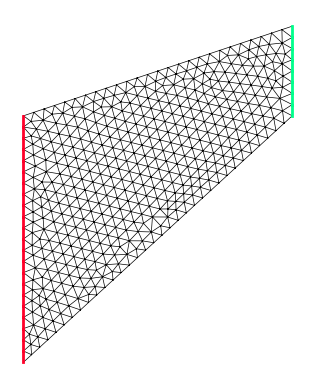

In [41]:
# mesh = skfem.MeshTri().load("cook_membrane.vtk")
mesh = skfem.MeshTri2().load("cook_membrane.vtk")

mesh = mesh.with_boundaries({
    "left": lambda x: np.isclose(x[0], 0.0),
    "right": lambda x: np.isclose(x[0], 48.0),
})

print(mesh)
draw(mesh, boundaries=True)


## FEM basis

In [42]:
# element = skfem.ElementVector(skfem.ElementTriP1(), 2)
element = skfem.ElementVector(skfem.ElementTriP2(), 2)

In [43]:
basis = skfem.Basis(mesh, element)

right_basis = skfem.FacetBasis(mesh, element, facets=mesh.boundaries["right"])

## Forms

In [44]:
from skfem.helpers import ddot, dot, sym_grad

@skfem.BilinearForm
def k(u,v,w):
    return ddot(sigma(sym_grad(u)), sym_grad(v))

@skfem.LinearForm
def b(v,w):
    t = np.array([0, 1])
    return dot(t, v)

## Assembling

In [45]:
K = skfem.asm(k, basis)
B = skfem.asm(b, right_basis)

In [46]:
cons = basis.get_dofs({"left"})

K_red, B_red, u_0, I = skfem.condense(K, B, D=cons)

## Solving

In [47]:
uh = skfem.solve(K_red, B_red, u_0, I)

## Postprocessing

<AxesSubplot: >

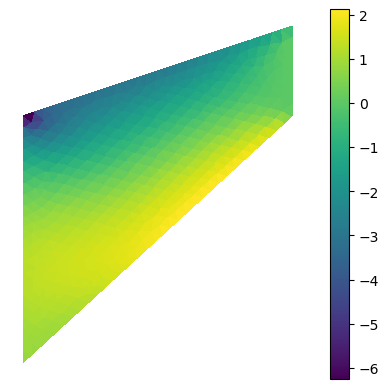

In [48]:
# Interpolate stress to gauss points 
ui = basis.interpolate(uh)

# Compute stress and reduce to one value per element by mean 
S = sigma(sym_grad(ui)).mean(axis=-1)

plot(mesh, S[0,0], cmap="viridis", colorbar=True)